In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

def epipolar_SIFT(img1, img2, n_matches):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    kp_img = cv2.drawKeypoints(img1, kp2, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    #plt.figure(figsize = (10,10))
    #plt.imshow(kp_img)
    bf = cv2.BFMatcher()
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance (i.e. best matches first).
    matches = sorted(matches, key = lambda x:x.distance)
    nb_matches = n_matches

    good = []
    pts1 = []
    pts2 = []

    for m in matches[:nb_matches]:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)

    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

    # We select only inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
    lines1 = lines1.reshape(-1, 3)
    img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
    lines2 = lines2.reshape(-1, 3)
    img3, img4 = drawlines(img2, img1, lines2, pts2, pts1)

    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
    axs[0, 0].imshow(img4, cmap = 'gray')
    axs[0, 0].set_title('left keypoints')
    axs[0, 1].imshow(img6, cmap = 'gray')
    axs[0, 1].set_title('right keypoints')
    axs[1, 0].imshow(img5, cmap = 'gray')
    axs[1, 0].set_title('left epipolar lines')
    axs[1, 1].imshow(img3, cmap = 'gray')
    axs[1, 1].set_title('right epipolar lines')
    plt.show()
    return img4,img6,img5,img3

## LEFT

In [3]:
def find_imgpoints_left():
   
    nb_vertical = 6
    nb_horizontal = 9

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
    objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints_l = [] # 3d point in real world space
    imgpoints_l = [] # 2d points in image plane.

    images = glob.glob('rs/left*.png')
    assert images


    for fname in images:
        img = cv2.imread(fname)
        h, w = img.shape[:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints_l.append(objp)

            imgpoints_l.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
            cv2.imshow('img',img)
            cv2.waitKey(50)

    cv2.destroyAllWindows()
    
    return objpoints_l, imgpoints_l, gray

objpoints_l, imgpoints_l, gray = find_imgpoints_left()
# print(np.asarray(objpoints_l).shape)
# print(np.asarray(imgpoints_l).shape)
# print(imgpoints_l)

# calibrateCamera: Finds the camera intrinsic and extrinsic parameters from several views of a calibration pattern
ret, mtx_l, dist_l, rvecs_l, tvecs_l = cv2.calibrateCamera(objpoints_l, imgpoints_l, gray.shape[::-1], None, None) 

In [6]:
# after calibrateCamera_l
print(mtx_l)
print(dist_l)

[[374.15541243   0.         322.54590143]
 [  0.         374.76827229 245.03655092]
 [  0.           0.           1.        ]]
[[-0.00355685 -0.00809662  0.00356797  0.00232191  0.00040122]]


In [ ]:
# # crop the image
# print(roi_l)
# x,y,w,h = roi_l
# dst_l = dst_l[y:y+h, x:x+w]
# plt.figure(figsize=(10,10))
# plt.imshow(dst_l[...,[2,1,0]])

# RIGHT

In [22]:
def find_imgpoints_right():
   
    nb_vertical = 6
    nb_horizontal = 9

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
    objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints_r = [] # 3d point in real world space
    imgpoints_r = [] # 2d points in image plane.

    images = glob.glob('rs/right*.png')
    assert images


    for fname in images:
        img = cv2.imread(fname)
        h, w = img.shape[:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints_r.append(objp)

            imgpoints_r.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
            cv2.imshow('img',img)
            cv2.waitKey(50)

    cv2.destroyAllWindows()
    
    return objpoints_r, imgpoints_r, gray

objpoints_r, imgpoints_r, gray = find_imgpoints_right()
# print(np.asarray(objpoints_r).shape)
# print(np.asarray(imgpoints_r).shape)
# print(imgpoints_r)

# calibrateCamera: Finds the camera intrinsic and extrinsic parameters from several views of a calibration pattern
ret, mtx_r, dist_r, rvecs_r, tvecs_r = cv2.calibrateCamera(objpoints_r, imgpoints_r, gray.shape[:2], None, None)

In [7]:
# after calibrateCamera_r
print(mtx_r)
print(dist_r)

[[375.12051591   0.         321.76648186]
 [  0.         375.43832019 244.06321705]
 [  0.           0.           1.        ]]
[[-0.0027914  -0.01328751  0.00292249  0.00138688  0.00552691]]


Text(0.5, 1.0, 'Undistorted right image')

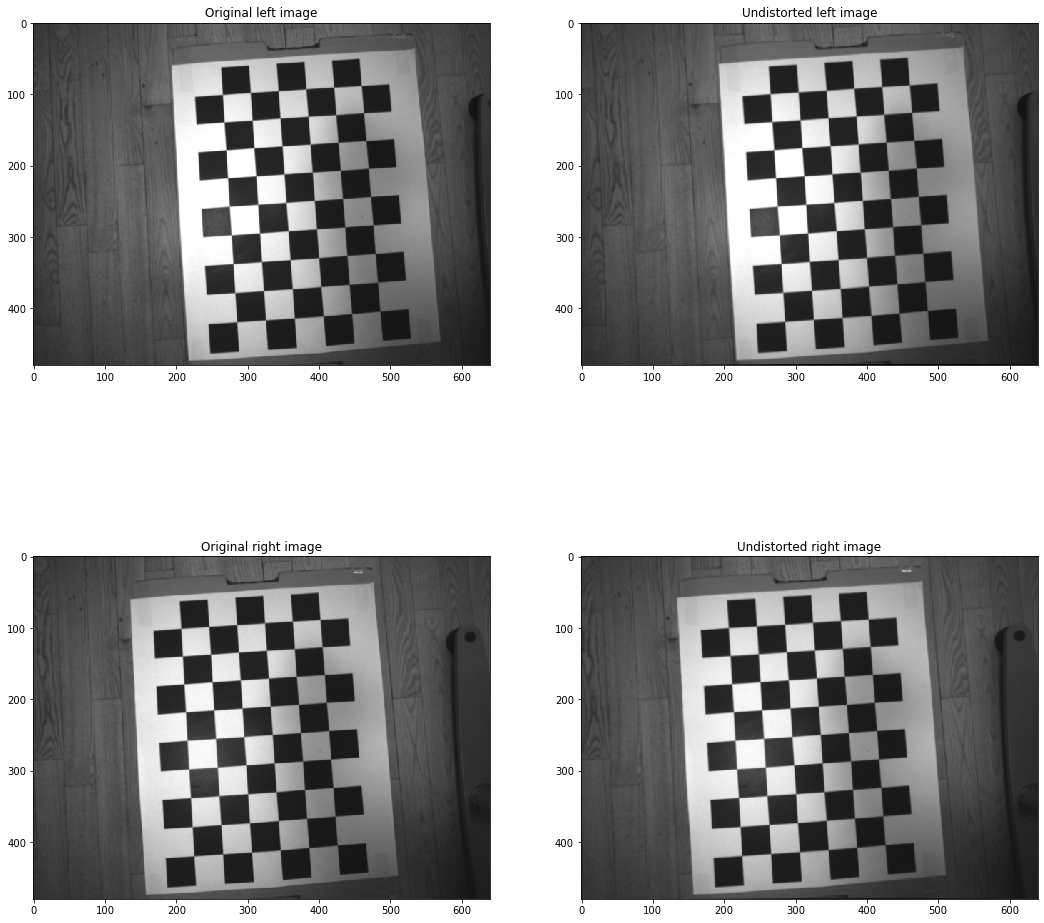

In [20]:
img_l = cv2.imread('rs/left-0013.png')
h,  w = img_l.shape[:2]
newcameramtx_l, roi_l = cv2.getOptimalNewCameraMatrix(mtx_l,dist_l,(w,h),1,(w,h))
dst_l = cv2.undistort(img_l, mtx_l, dist_l, None, None)

img_r = cv2.imread('rs/right-0013.png')
h, w = img_r.shape[:2]
newcameramtx_r, roi_r = cv2.getOptimalNewCameraMatrix(mtx_r,dist_r,(w,h),1,(w,h))
dst_r = cv2.undistort(img_r, mtx_r, dist_r, None, None)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
ax[0,0].imshow(img_l[...,[2,1,0]])
ax[0,0].set_title('Original left image')
ax[0,1].imshow(dst_l[...,[2,1,0]])
ax[0,1].set_title('Undistorted left image')
ax[1,0].imshow(img_r[...,[2,1,0]])
ax[1,0].set_title('Original right image')
ax[1,1].imshow(dst_r[...,[2,1,0]])
ax[1,1].set_title('Undistorted right image')

In [ ]:
# # crop the image
# print(roi_right)
# x,y,w,h = roi_right
# dst_right = dst_right[y:y+h, x:x+w]
# plt.figure(figsize=(10,10))
# plt.imshow(dst_right[...,[2,1,0]])

In [9]:
h,w = dst_l.shape[:2]
# StereoCalibrate: find R,T,E,F
# ret, mtx1, dist1, mtx2, dist2, R, T, E, F
h,w = (dst_l.shape[:2])
retval,cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(objpoints_l,
                                                                                                imgpoints_l,
                                                                                                imgpoints_r,
                                                                                                mtx_l,
                                                                                                dist_l,
                                                                                                mtx_r,
                                                                                                dist_r,
                                                                                                (w,h),
                                                                                                flags = cv2.CALIB_FIX_INTRINSIC)
print(cameraMatrix1)
print(distCoeffs1)
print(cameraMatrix2)
print(distCoeffs2)
print(R)
print(T)
print(E)
print(F)

[[374.15541243   0.         322.54590143]
 [  0.         374.76827229 245.03655092]
 [  0.           0.           1.        ]]
[[-0.00355685 -0.00809662  0.00356797  0.00232191  0.00040122]]
[[375.12051591   0.         321.76648186]
 [  0.         375.43832019 244.06321705]
 [  0.           0.           1.        ]]
[[-0.0027914  -0.01328751  0.00292249  0.00138688  0.00552691]]
[[ 9.99998209e-01 -6.30030457e-04  1.78484884e-03]
 [ 6.25305393e-04  9.99996302e-01  2.64664113e-03]
 [-1.78650971e-03 -2.64552031e-03  9.99994905e-01]]
[[-1.48135966e+00]
 [ 6.18691155e-04]
 [ 1.31680650e-02]]
[[-9.33935983e-06 -1.31696531e-02  5.83836860e-04]
 [ 1.05215780e-02 -3.92726336e-03  1.48137562e+00]
 [-1.54499223e-03 -1.48135380e+00 -3.92173169e-03]]
[[ 9.48383589e-08  1.33515127e-04 -3.49649258e-02]
 [-1.06752983e-04  3.97812461e-05 -5.59894028e+00]
 [ 3.19091989e-02  5.58092681e+00  1.00000000e+00]]


In [11]:
# stereoRectify: Computes rectification transforms for each head of a calibrated stereo camera.
# R1, R2, P1, P2, Q, validPixROI1, validPixROI2 
R1, R2, P1, P2, Q, validPixROI1, validPixROI2  = cv2.stereoRectify(mtx_l,
                                                                   dist_l,
                                                                   mtx_r,
                                                                   dist_r,
                                                                   gray.shape,
                                                                   R,
                                                                   T,
                                                                   flags=cv2.CALIB_ZERO_DISPARITY,
                                                                   alpha=0.9)
print(R1)
print(R2)
print(P1)
print(P2)

[[ 0.99997423 -0.00102412 -0.0071051 ]
 [ 0.00103355  0.99999859  0.00132382]
 [ 0.00710374 -0.00133113  0.99997388]]
[[ 9.99960406e-01 -4.17634335e-04 -8.88882287e-03]
 [ 4.05885249e-04  9.99999042e-01 -1.32354494e-03]
 [ 8.88936711e-03  1.31988469e-03  9.99959618e-01]]
[[361.59821445   0.         330.69511414   0.        ]
 [  0.         361.59821445 244.99605942   0.        ]
 [  0.           0.           1.           0.        ]]
[[ 361.59821445    0.          330.69511414 -535.67821855]
 [   0.          361.59821445  244.99605942    0.        ]
 [   0.            0.            1.            0.        ]]


In [12]:
xmap_l, ymap_l = cv2.initUndistortRectifyMap(
                                            cameraMatrix = mtx_l,
                                            distCoeffs = dist_l,
                                            R = R1,
                                            newCameraMatrix = P1,
                                            size = (w,h),
                                            m1type=cv2.CV_32FC1)

xmap_l, ymap_r = cv2.initUndistortRectifyMap(
                                            cameraMatrix = mtx_r,
                                            distCoeffs = dist_r,
                                            R = R2,
                                            newCameraMatrix = P2,
                                            size = (w,h),
                                            m1type=cv2.CV_32FC1)

In [15]:
img1 = cv2.imread("rs/left-0013.png", 0)
img2 = cv2.imread("rs/right-0013.png", 0)

dst_l = cv2.undistort(img1, mtx_l, dist_l, None, None)
dst_r = cv2.undistort(img2, mtx_r, dist_r, None, None)

rect_l = cv2.remap(dst_l, xmap_l, ymap_l, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rect_r = cv2.remap(dst_r, xmap_l, ymap_r, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,18))
# ax[0,0].imshow(dst_l, cmap='gray')
# ax[0,0].set_title('Left original image')
# ax[0,1].imshow(rect_l, cmap='gray')
# ax[0,1].set_title('Left rectified image')
# ax[1,0].imshow(dst_r, cmap='gray')
# ax[1,0].set_title('Right original image')
# ax[1,1].imshow(rect_r, cmap='gray')
# ax[1,1].set_title('Right rectified image')

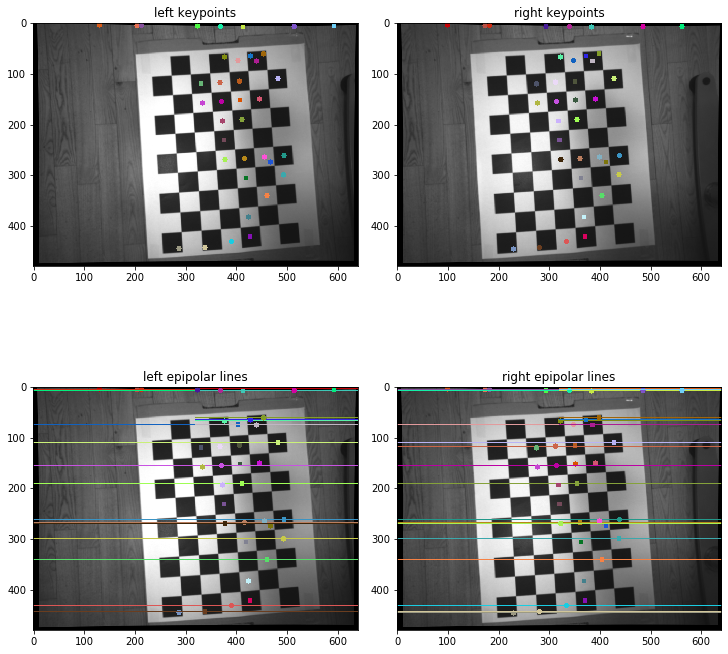

In [16]:
img4,img6,img5,img3 = epipolar_SIFT(rect_l, rect_r, 50)